### Import Libraries

In [1]:
# Bibliotecas RAPIDS (GPU)
from cuml.preprocessing import StandardScaler
from cuml.pipeline import Pipeline
from cuml.neighbors import KNeighborsClassifier
from cuml.svm import SVC
from cuml.ensemble import RandomForestClassifier
import xgboost as xgb
from cuml.metrics import accuracy_score
from cuml.metrics import confusion_matrix

# Bibliotecas Scikit-learn (CPU)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold 
from sklearn.preprocessing import StandardScaler as SklearnStandardScaler # Necessário para o MLP na CPU/TF
from sklearn.metrics import precision_recall_fscore_support

# Bibliotecas de Utilidades
import optuna
from optuna.samplers import TPESampler
optuna.logging.set_verbosity(optuna.logging.WARNING)
import cupy as cp  # cupy é o "numpy" do RAPIDS
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import gc

# Bibliotecas TensorFlow
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Configuração para não travar a memória da GPU com o TF, permitindo rodar junto com o RAPIDS
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

/home/zurua/miniconda3/envs/rapids-fma/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-12-12 00:48:37.513773: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Audio Preprocessing

In [2]:
# 1. Carregar os dados oficiais
METADATA_DIR = '../fma_metadata' 
tracks = utils.load(f'{METADATA_DIR}/tracks.csv')
features = utils.load(f'{METADATA_DIR}/features.csv')

# 2. Filtrar pelo dataset 'small'
small_mask = tracks[('set', 'subset')] == 'small'

X_all_pd = features.loc[small_mask] # Deixar como Pandas DataFrame
y_all_labels_pd = tracks.loc[small_mask, ('track', 'genre_top')] # Deixar como Pandas Series
splits = tracks.loc[small_mask, ('set', 'split')]

y_all_labels_pd = y_all_labels_pd.astype(str)

print(f"Total de faixas 'fma_small': {X_all_pd.shape[0]}")
print(f"Total de features: {X_all_pd.shape[1]}")

# 3. EXTRAIR GRUPOS (ARTIST ID) - NOVO
groups_np = tracks.loc[small_mask, ('artist', 'id')].to_numpy()

# 4. Codificar os Gêneros (Labels) - Usando Sklearn
label_encoder = LabelEncoder()
y_all_encoded_np = label_encoder.fit_transform(y_all_labels_pd).astype(np.int32) # Array Numpy

# 5. Converter X para Numpy (para o loop do sklearn)
X_all_np = X_all_pd.to_numpy()

Total de faixas 'fma_small': 8000
Total de features: 518


In [3]:
# Converta para float32 para economizar RAM e VRAM
X_data = X_all_np.astype(np.float32)
y_data = y_all_encoded_np.astype(np.int32)
groups = groups_np

# Definir número de classes
num_classes = len(np.unique(y_data))

### Treino dos Modelos

In [4]:
def build_reference_mlp(input_shape, num_classes, params):
    # Extrai os parâmetros otimizados ou usa defaults se não existirem
    l2_reg = params.get('l2_reg', 0.002)
    dropout_rate = params.get('dropout', 0.4)
    lr = params.get('lr', 0.0005)
    
    model = keras.Sequential([
        layers.Input(shape=(input_shape,)),
        
        # Camada 1
        layers.Dense(512, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.ELU(),
        layers.Dropout(dropout_rate),

        # Camada 2
        layers.Dense(256, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.ELU(),
        layers.Dropout(dropout_rate),
        
        # Camada 3
        layers.Dense(128, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.ELU(),
        layers.Dropout(dropout_rate),
        
        # Camada 4
        layers.Dense(64, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.ELU(),
        
        # Saída
        layers.Dense(num_classes, activation='softmax', kernel_initializer='glorot_uniform')
    ])
    
    optimizer = tf.keras.optimizers.AdamW(learning_rate=lr) 
    
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [5]:
def objective(trial, model_name, X, y, groups):
    # Split interno para validação rápida (3-fold é suficiente para tuning)
    # Usamos GroupKFold para manter a consistência com sua estratégia de artista
    inner_cv = GroupKFold(n_splits=3)
    
    # --- ESPAÇO DE BUSCA DOS HIPERPARÂMETROS ---
    if model_name == "KNN (GPU)":
        n_neighbors = trial.suggest_int("n_neighbors", 3, 40)
        
        # CuML KNN geralmente usa 'uniform', verifique a doc se 'distance' é suportado na sua versão
        model = KNeighborsClassifier(n_neighbors=n_neighbors)
        
    elif model_name == "SVM (GPU)":
        C = trial.suggest_float("C", 0.1, 100.0, log=True)
        gamma = trial.suggest_categorical("gamma", ["scale", "auto"])
        kernel = trial.suggest_categorical("kernel", ["rbf", "poly"]) 
        model = SVC(C=C, gamma=gamma, kernel=kernel, probability=False) # Prob=False é mais rápido
        
    elif model_name == "Random Forest (GPU)":
        n_estimators = trial.suggest_int("n_estimators", 50, 300)
        max_depth = trial.suggest_int("max_depth", 5, 30)
        max_features = trial.suggest_float("max_features", 0.1, 1.0)
        model = RandomForestClassifier(n_estimators=n_estimators, 
                                       max_depth=max_depth, 
                                       max_features=max_features)
        
    elif model_name == "XGBoost (GPU)":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "tree_method": "hist",
            "device": "cuda",
            "verbosity": 0,
            "objective": 'multi:softmax',
            "num_class": num_classes
        }
        model = xgb.XGBClassifier(**params)

    elif model_name == "MLP (Keras)":
        # Para Keras, precisamos construir o modelo a cada trial
        # Definindo hiperparâmetros da arquitetura
        l2_reg = trial.suggest_float("l2_reg", 1e-5, 1e-2, log=True)
        dropout = trial.suggest_float("dropout", 0.1, 0.5)
        lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
        units_1 = trial.suggest_int("units_1", 128, 512, step=64)
        
        # Como o Keras não segue a API sklearn perfeitamente para cross_val_score,
        # fazemos um loop manual rápido aqui
        scores = []
        for train_idx, val_idx in inner_cv.split(X, y, groups=groups):
            X_t, X_v = X[train_idx], X[val_idx]
            y_t, y_v = y[train_idx], y[val_idx]

            # === [INSERÇÃO] SELEÇÃO DE FEATURES PARA MLP ===
            # Usamos uma versão leve do XGBoost para selecionar rápido
            fs_model = xgb.XGBClassifier(
                n_estimators=50,
                max_depth=3,
                tree_method='hist',
                device="cuda", 
                random_state=42,
                objective='multi:softmax',
                num_class=num_classes,
                verbosity=0
            )
            
            fs_model.fit(X_t, y_t)
            
            importances = fs_model.feature_importances_
            # Threshold adaptativo: Média * 1.25 (igual ao seu loop principal)
            threshold = np.mean(importances) * 1.25
            select_mask = importances > threshold
            
            # Fallback: Se selecionar muito poucas (<10), pega as top 20
            if np.sum(select_mask) < 10:
                top_indices = np.argsort(importances)[-20:]
                select_mask[:] = False
                select_mask[top_indices] = True
            
            X_t = X_t[:, select_mask]
            X_v = X_v[:, select_mask]
            # ===============================================
            
            # Scaling (Necessário para MLP)
            scaler = SklearnStandardScaler()
            X_t = scaler.fit_transform(X_t)
            X_v = scaler.transform(X_v)
            
            # Build
            k_model = keras.Sequential([
                layers.Input(shape=(X_t.shape[1],)),
                layers.Dense(units_1, kernel_regularizer=regularizers.l2(l2_reg)),
                layers.BatchNormalization(), layers.ELU(), layers.Dropout(dropout),
                layers.Dense(units_1 // 2, kernel_regularizer=regularizers.l2(l2_reg)),
                layers.BatchNormalization(), layers.ELU(), layers.Dropout(dropout),
                layers.Dense(num_classes, activation='softmax')
            ])
            k_model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=lr),
                            loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            
            # Train (Menos épocas para otimização ser rápida)
            k_model.fit(X_t, y_t, epochs=20, batch_size=64, verbose=0)
            
            # Eval
            acc = k_model.evaluate(X_v, y_v, verbose=0)[1]
            scores.append(acc)
            
            # Limpeza
            del k_model
            tf.keras.backend.clear_session()
            cp.get_default_memory_pool().free_all_blocks()
            gc.collect()
            
        return np.mean(scores)

    # --- AVALIAÇÃO PADRÃO (RAPIDS/XGBoost) ---
    # Para modelos que não são Keras, usamos lógica similar de loop manual
    # para garantir conversão correta para CuPY/GPU
    
    scores = []
    for train_idx, val_idx in inner_cv.split(X, y, groups=groups):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        # === [INSERÇÃO] SELEÇÃO DE FEATURES PARA MLP ===
        # Usamos uma versão leve do XGBoost para selecionar rápido
        fs_model = xgb.XGBClassifier(
            n_estimators=50,
            max_depth=3,
            tree_method='hist',
            device="cuda", 
            random_state=42,
            objective='multi:softmax',
            num_class=num_classes,
            verbosity=0
        )
        
        fs_model.fit(X_train_fold, y_train_fold)
        
        importances = fs_model.feature_importances_
        # Threshold adaptativo: Média * 1.25 (igual ao seu loop principal)
        threshold = np.mean(importances) * 1.25
        select_mask = importances > threshold
        
        # Fallback: Se selecionar muito poucas (<10), pega as top 20
        if np.sum(select_mask) < 10:
            top_indices = np.argsort(importances)[-20:]
            select_mask[:] = False
            select_mask[top_indices] = True
        
        X_train_fold = X_train_fold[:, select_mask]
        X_val_fold = X_val_fold[:, select_mask]
        # ===============================================
        
        # Scaling se necessário (Pipelines fariam isso, mas aqui estamos raw)
        if model_name in ["KNN (GPU)", "SVM (GPU)"]:
            scaler = StandardScaler() # cuML scaler
            X_train_fold = cp.array(X_train_fold)
            X_val_fold = cp.array(X_val_fold)
            y_train_fold = cp.array(y_train_fold)
            y_val_fold = cp.array(y_val_fold)
            
            X_train_fold = scaler.fit_transform(X_train_fold)
            X_val_fold = scaler.transform(X_val_fold)
        elif model_name == "XGBoost (GPU)":
             # XGBoost lida bem com numpy ou cupy, mas vamos manter numpy ou passar direto
             pass
        else:
             # Random Forest
             X_train_fold = cp.array(X_train_fold).astype(np.float32)
             X_val_fold = cp.array(X_val_fold).astype(np.float32)
             y_train_fold = cp.array(y_train_fold).astype(np.int32)
             y_val_fold = cp.array(y_val_fold).astype(np.int32)

        model.fit(X_train_fold, y_train_fold)
        preds = model.predict(X_val_fold)
        
        # Accuracy
        if isinstance(preds, cp.ndarray):
            preds = cp.asnumpy(preds)
        if isinstance(y_val_fold, cp.ndarray):
            y_val_fold = cp.asnumpy(y_val_fold)
            
        scores.append(accuracy_score(y_val_fold, preds))
        
    return np.mean(scores)

In [6]:
# Lista de modelos a otimizar
target_models = ["KNN (GPU)", "SVM (GPU)", "Random Forest (GPU)", "XGBoost (GPU)", "MLP (Keras)"]
best_models_config = {}

print("--- INICIANDO OTIMIZAÇÃO DE HIPERPARÂMETROS (OPTUNA) ---")

# Usa-se uma amostra dos dados para otimização caso o dataset for muito grande
# Mas como FMA_small é pequeno, pode-se usar tudo.
X_opt = X_all_np
y_opt = y_all_encoded_np
groups_opt = groups_np

for name in target_models:
    print(f"\nOtimizando {name}...")
    
    # Define a função de estudo específica para o modelo atual
    study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=42))
    
    # Lambda para passar os argumentos extras
    func = lambda trial: objective(trial, name, X_opt, y_opt, groups_opt)
    
    # Número de tentativas (trials). 
    # Para testes rápidos use 10-20. Para resultado final use 50-100.
    n_trials = 20 if name != "MLP (Keras)" else 10 
    
    study.optimize(func, n_trials=n_trials)
    
    print(f"Melhores params para {name}: {study.best_params}")
    print(f"Melhor score (CV interno): {study.best_value:.4f}")
    
    best_models_config[name] = study.best_params
    tf.keras.backend.clear_session()
    cp.get_default_memory_pool().free_all_blocks()
    gc.collect()

print("\n--- OTIMIZAÇÃO CONCLUÍDA ---")

--- INICIANDO OTIMIZAÇÃO DE HIPERPARÂMETROS (OPTUNA) ---

Otimizando KNN (GPU)...
Melhores params para KNN (GPU): {'n_neighbors': 27}
Melhor score (CV interno): 0.4476

Otimizando SVM (GPU)...
Melhores params para SVM (GPU): {'C': 1.3766157379784636, 'gamma': 'scale', 'kernel': 'rbf'}
Melhor score (CV interno): 0.5262

Otimizando Random Forest (GPU)...
Melhores params para Random Forest (GPU): {'n_estimators': 296, 'max_depth': 21, 'max_features': 0.4055904018330261}
Melhor score (CV interno): 0.4975

Otimizando XGBoost (GPU)...
Melhores params para XGBoost (GPU): {'n_estimators': 436, 'max_depth': 10, 'learning_rate': 0.058218083468221736, 'subsample': 0.5427925342039944, 'colsample_bytree': 0.5018684889065917}
Melhor score (CV interno): 0.5305

Otimizando MLP (Keras)...
Melhores params para MLP (Keras): {'l2_reg': 2.9380279387035334e-05, 'dropout': 0.16239780813448107, 'lr': 0.00013066739238053285, 'units_1': 512}
Melhor score (CV interno): 0.5214

--- OTIMIZAÇÃO CONCLUÍDA ---


In [7]:
# 4. Definir a Estratégia de CV
# Usar StratifiedKFold é ideal para classificação, pois mantém
# a proporção de classes em cada fold (o fma_small é balanceado,
# mas esta é uma boa prática).
n_splits = 10
kf = GroupKFold(n_splits=n_splits)

# 5. Criar Pipelines para os Modelos
# Isso garante que o StandardScaler seja "fitado" apenas nos dados
# de treino de cada fold, e depois "transforma" os dados de treino e teste.

# Recriar os modelos finais com os melhores parâmetros encontrados
models = {}

# 1. KNN
p_knn = best_models_config["KNN (GPU)"]
# Nota: precisamos recriar o Pipeline pois o scaler é parte dele
models["KNN (GPU)"] = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=p_knn['n_neighbors']))
])

# 2. SVM
p_svm = best_models_config["SVM (GPU)"]
models["SVM (GPU)"] = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(C=p_svm['C'], gamma=p_svm['gamma'], kernel=p_svm['kernel']))
])

# 3. Random Forest
p_rf = best_models_config["Random Forest (GPU)"]
models["Random Forest (GPU)"] = RandomForestClassifier(
    n_estimators=p_rf['n_estimators'],
    max_depth=p_rf['max_depth'],
    max_features=p_rf['max_features']
)

# 4. XGBoost
p_xgb = best_models_config["XGBoost (GPU)"]
# Adicionamos parâmetros fixos necessários que não foram otimizados
p_xgb.update({
    "tree_method": 'hist', "device": "cuda", 
    "objective": 'multi:softmax', "num_class": num_classes,
    "random_state": 42
})
models["XGBoost (GPU)"] = xgb.XGBClassifier(**p_xgb)

# 5. MLP
# Para o MLP, passaremos o dicionário de config diretamente para ser usado dentro do loop de treino principal
# Você precisará alterar levemente a função `build_reference_mlp` ou o loop principal
# para aceitar esses parâmetros dinâmicos (lr, dropout, l2, units).
models["MLP (Keras)"] = best_models_config["MLP (Keras)"]

# 6. Treinar de Modelos
# Dicionário para guardar os scores de CADA métrica para cada modelo
# Ex: cv_scores['KNN']['Accuracy'] = [0.5, 0.52, ...]
cv_scores = {}

# Dicionário para guardar as previsões e rótulos de todos os folds,
# para a matriz de confusão final
out_of_fold_preds = {}

print(f"Iniciando treinamento com {n_splits} folds...")
print(f"Shape dos dados: {X_all_np.shape}")

debug_feature_selection_flag = True

# --- LOOP DOS MODELOS ---
for model_name, model in models.items():
    print(f"\nIniciando CV 10-Fold para {model_name}...")
    
    fold_scores_acc = []
    fold_scores_precision = []
    fold_scores_recall = []
    fold_scores_f1 = []
    
    all_y_true = []
    all_y_pred = []

    y_pred_fold = None # Variável para guardar as previsões deste fold

    # --- LOOP DOS K-FOLDS ---
    for fold, (train_idx, test_idx) in enumerate(kf.split(X_all_np, y_all_encoded_np, groups=groups_np)):
        # Dados em Numpy (CPU) inicialmente
        X_train, X_test = X_all_np[train_idx], X_all_np[test_idx]
        y_train, y_test = y_all_encoded_np[train_idx], y_all_encoded_np[test_idx]

        # === SELEÇÃO DE FEATURES COM XGBOOST (GPU) ===
        ## A. Treinar o seletor rápido
        feature_selection_model = xgb.XGBClassifier(
            n_estimators=50,
            max_depth=3,
            tree_method='hist',
            device="cuda", 
            random_state=42,
            objective='multi:softmax',
            num_class=num_classes,
            verbosity=0
        )
        feature_selection_model.fit(X_train, y_train)

        ## B. Calcular Importâncias
        importances = feature_selection_model.feature_importances_

        ## C. Definir o Limiar
        ## Isso é uma heurística comum: "Seja um pouco melhor que a média para ficar"
        threshold = np.mean(importances) * 1.25 # ...altere esse número para alterar o limiar

        ## Seleciona booleanos onde a importância > threshold
        select_mask = importances > threshold

        ## D. Filtrar
        # Fallback: Se selecionar muito poucas (<10), pega as top 20
        if np.sum(select_mask) < 10:
            top_indices = np.argsort(importances)[-20:]
            select_mask[:] = False
            select_mask[top_indices] = True
            
        X_train = X_train[:, select_mask]
        X_test = X_test[:, select_mask]

        # Debug: Mostra quantas features foram selecionadas.
        if debug_feature_selection_flag == True:
            n_selected = np.sum(select_mask)
            print(f"O modelo escolheu automaticamente {n_selected} features relevantes.")

            debug_feature_selection_flag = False
        
        # =============================================
        
        # --- TREINO DOS MODELOS ---
        ## 1. MLP (TensorFlow/Keras)
        if model_name == "MLP (Keras)":
            # Scaling na CPU para o TF
            scaler = SklearnStandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Build & Train
            best_params = model
            keras_model = build_reference_mlp(X_train.shape[1], num_classes, best_params)
            callbacks_list = [
                # Para se o modelo não melhorar por 8 épocas (evita desperdício)
                EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
                
                # Reduz a taxa de aprendizado se o modelo estagnar (O "Pulo do Gato")
                # Se o loss não cair por 3 épocas, divide o LR por 5. 
                # Isso ajuda o modelo a descer o "vale" do mínimo global com passos menores.
                tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss', 
                    factor=0.2, 
                    patience=3, 
                    min_lr=1e-6,
                    verbose=1
                )
            ]

            # Treinamento
            history = keras_model.fit(
                X_train_scaled, y_train,
                epochs=70,
                batch_size=32,
                validation_split=0.1,
                callbacks=callbacks_list,
                verbose=0
            )
            
            # Predict
            y_probs = keras_model.predict(X_test_scaled, verbose=0)
            y_pred_fold = np.argmax(y_probs, axis=1)
            
            # Limpeza Crítica para GPU 6GB
            tf.keras.backend.clear_session()
            del keras_model, X_train_scaled, X_test_scaled
            gc.collect()

        ## 2. Modelos GPU
        elif "(GPU)" in model_name:
            # Converter para CuPy (GPU)
            X_train_cp = cp.array(X_train)
            X_test_cp = cp.array(X_test)
            y_train_cp = cp.array(y_train)
            
            model.fit(X_train_cp, y_train_cp)
            y_pred_cp = model.predict(X_test_cp)
            
            # Trazer de volta para CPU para métricas unificadas depois
            y_pred_fold = cp.asnumpy(y_pred_cp)
            
            # Limpeza
            del X_train_cp, X_test_cp, y_train_cp, y_pred_cp
        
        # Acurácia (cuml accuracy_score aceita numpy e devolve float ou array 0-d)
        acc = accuracy_score(y_test, y_pred_fold)
        fold_scores_acc.append(acc)
        
        # Calculo dos precision_recall_fscore_support
        macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(y_test, y_pred_fold, average='macro', zero_division=0)
        
        # Converter métricas scalarem de volta para CPU/float para armazenar na lista
        fold_scores_precision.append(float(macro_p))
        fold_scores_recall.append(float(macro_r))
        fold_scores_f1.append(float(macro_f1))
        
        # Acumular para Matriz Final
        all_y_true.append(y_test)
        all_y_pred.append(y_pred_fold)
    
    # Armazenar resultados do modelo
    cv_scores[model_name] = {
        'Acurácia': np.array(fold_scores_acc),
        'Precisão': np.array(fold_scores_precision),
        'Recall': np.array(fold_scores_recall),
        'F1-Score': np.array(fold_scores_f1)
    }
    
    out_of_fold_preds[model_name] = {
        'y_true': np.concatenate(all_y_true),
        'y_pred': np.concatenate(all_y_pred)
    }
    
    # Limpeza final do modelo
    gc.collect()
    cp.get_default_memory_pool().free_all_blocks()

print("\n--- Avaliação Concluída ---")

Iniciando treinamento com 10 folds...
Shape dos dados: (8000, 518)

Iniciando CV 10-Fold para KNN (GPU)...
O modelo escolheu automaticamente 108 features relevantes.

Iniciando CV 10-Fold para SVM (GPU)...

Iniciando CV 10-Fold para Random Forest (GPU)...

Iniciando CV 10-Fold para XGBoost (GPU)...

Iniciando CV 10-Fold para MLP (Keras)...

Epoch 15: ReduceLROnPlateau reducing learning rate to 2.6133478968404233e-05.

Epoch 18: ReduceLROnPlateau reducing learning rate to 5.226695793680847e-06.
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 12.

Epoch 17: ReduceLROnPlateau reducing learning rate to 2.6133478968404233e-05.

Epoch 20: ReduceLROnPlateau reducing learning rate to 5.226695793680847e-06.
Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 14.

Epoch 13: ReduceLROnPlateau reducing learning rate to 2.6133478968404233e-05.

Epoch 16: ReduceLROnPlateau reducing learning rate to 5.226695793680847e-06.
Epoch 18: early s

### Análise de Resultados


========= KNN (GPU) =========
Acurácia       : Média 0.4479 | Std 0.0426
Precisão       : Média 0.4577 | Std 0.0334
Recall         : Média 0.4579 | Std 0.0309
F1-Score       : Média 0.4185 | Std 0.0367

========= SVM (GPU) =========
Acurácia       : Média 0.5275 | Std 0.0440
Precisão       : Média 0.5180 | Std 0.0425
Recall         : Média 0.5303 | Std 0.0406
F1-Score       : Média 0.5151 | Std 0.0420

========= Random Forest (GPU) =========
Acurácia       : Média 0.4987 | Std 0.0405
Precisão       : Média 0.4839 | Std 0.0400
Recall         : Média 0.5032 | Std 0.0390
F1-Score       : Média 0.4821 | Std 0.0401

========= XGBoost (GPU) =========
Acurácia       : Média 0.5378 | Std 0.0396
Precisão       : Média 0.5241 | Std 0.0389
Recall         : Média 0.5396 | Std 0.0383
F1-Score       : Média 0.5226 | Std 0.0388

========= MLP (Keras) =========
Acurácia       : Média 0.5230 | Std 0.0380
Precisão       : Média 0.5040 | Std 0.0386
Recall         : Média 0.5226 | Std 0.0353
F1-Score    

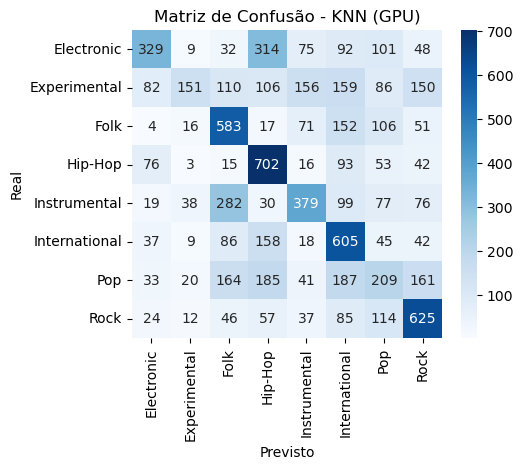

--- SVM (GPU) ---


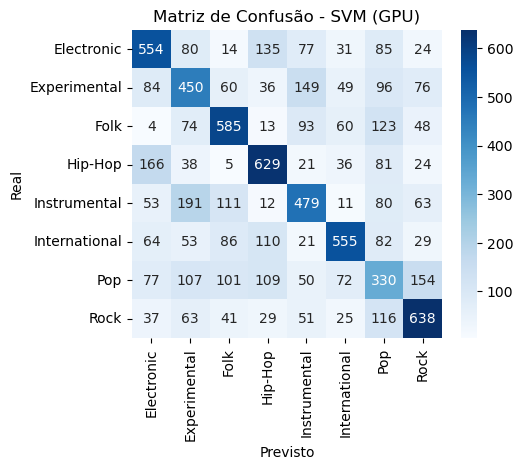

--- Random Forest (GPU) ---


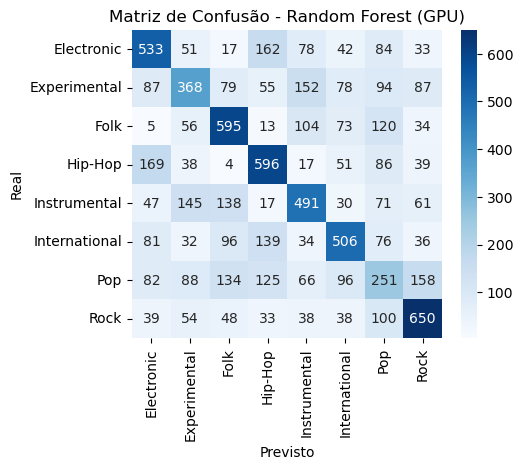

--- XGBoost (GPU) ---


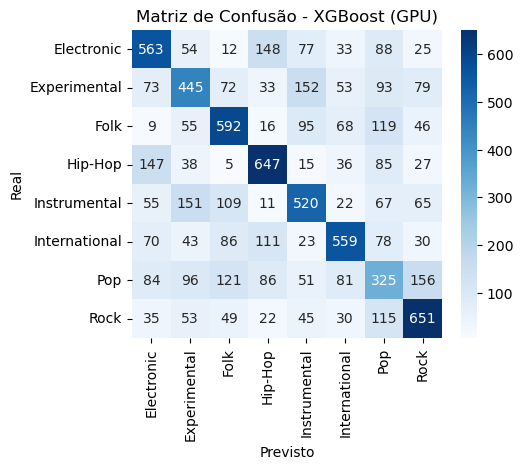

--- MLP (Keras) ---


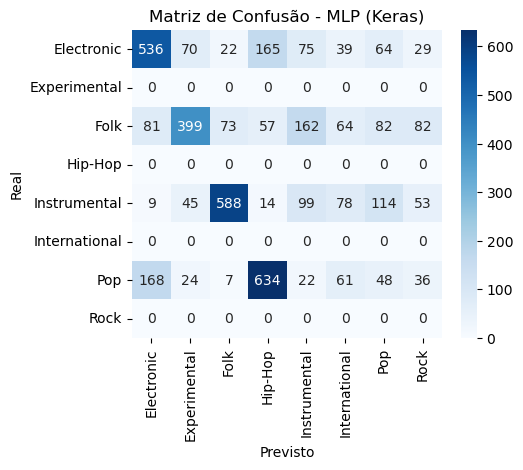

In [8]:
# 4. Exibição dos Resultados
for model_name, metrics in cv_scores.items():
    print(f"\n========= {model_name} =========")
    for metric_name, values in metrics.items():
        print(f"{metric_name:15}: Média {values.mean():.4f} | Std {values.std():.4f}")

# 5. Plot das Matrizes de Confusão
print("\n========= Matrizes de Confusão Agregadas =========")
class_names = label_encoder.classes_ # Nomes dos gêneros

for model_name, results in out_of_fold_preds.items():
    print(f"--- {model_name} ---")
    
    # Calcular CM total usando cuML
    cm_gpu = confusion_matrix(results['y_true'], results['y_pred'])
    cm_cpu = cp.asnumpy(cm_gpu) # Mover para CPU para o Seaborn
    
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_cpu, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.ylabel('Real')
    plt.xlabel('Previsto')
    plt.show()